In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import re
from torch.nn.functional import conv2d
import functools
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%load_ext autoreload

%autoreload 2

In [2]:
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf import *
from crf.depth import *

In [3]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
gt_depth = read_pgm('truedisp.row3.col3.pgm')
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
## Hyper parameters
ws = 9      # Disparity aggregation window size
gamma = 3    # Charbonneir turning point
sigma_c = .1 # Filter stdev for color channels
sigma_p = .1 # Filter stdev for position channels
sigma_f = 10 # Filter stdev for feature channels
n_iters = 30 # Number of mean field message passing iterations

In [5]:
# Get the unary potentials from window sweep
disp_energy = disparity_badness(img1,img2,ws)
disps = np.argmin(disp_energy,axis=-1)
L = disp_energy.shape[-1] # Number of possible disparities
downsampled_out = disp_energy[::4,::4]
h,w,_ = downsampled_out.shape
n = h*w

E_0 = torch.from_numpy(downsampled_out.reshape(-1,L)).float().to(device)

In [6]:
# Setup the compatibility matrix
labels = torch.arange(L).float()
charb = lambda a,b: charbonneir(a,b,gamma)
Mu = compatibility_matrix(charb,labels).to(device)

In [7]:
# Get random projection of VGG16 features
VGG = Vgg16features()
VGG.to(device)
q = 2
features = s.get_random_features(img1,i=q)
feats = (features - features.mean((0,1)))/features.std((0,1))

/home/marc/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [8]:
# Calculate W matrix with brute force
position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)
ref = np.zeros((h,w,5))
ref[...,:3] = img1[::4,::4]/sigma_c
ref[...,3:5] = position/sigma_p
#ref[...,5:] = feats[::2**(2-q),::2**(2-q)]/sigma_f
flat_ref = torch.from_numpy(ref.reshape(n,-1).astype(np.float32))
W = gaussian_weights(flat_ref.to(device))
img_W = W.reshape((h,w,h,w))

In [9]:
mf = mean_field_infer(E_0/100,W,Mu,n_iters)
expected_depths = mf@labels.to(device)
crf_depth = expected_depths.reshape(h,w).cpu().numpy()

Text(0.5, 1.0, 'Ground Truth')

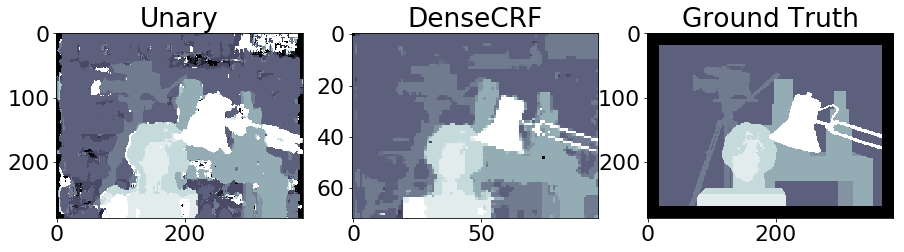

In [10]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(1,3,figsize=(15,10))
a0 = axarr[0].imshow(4*disps,cmap='bone',vmin=0,vmax=L)
a1 = axarr[1].imshow(4*crf_depth,cmap='bone',vmin=0,vmax=L)
a2 = axarr[2].imshow(gt_depth/4,cmap='bone',vmin=0,vmax=L)
axarr[0].set_title("Unary")
axarr[1].set_title("DenseCRF")
axarr[2].set_title("Ground Truth")

In [21]:
%matplotlib widget


f, axarr = plt.subplots(1,2)
shape = (3,5)
im1 = np.random.rand(*shape)
ax0 = axarr[0].imshow(img1[::4,::4])  # 5 points tolerance
ax1 = axarr[1].imshow(img1[::4,::4])
rotate_left = np.array([[0,-1],[1,0]])
rotate_right = np.linalg.inv(rotate_left)

position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)
all_features = VGG.get_all_features(img1)


def callback(i,j):
    if axarr[1].lines:
        axarr[1].lines[-1].remove()
    n,m = im1.shape[:2]
    #ax1.set_data(img_W[i,j])
    ax1.set_data(20*f.get_W(i,j))
    coords = [j,i]
    axarr[1].plot(*coords,".r",markersize=4)
    
def handler(fig, axes,callback, event):
    if fig.frozen: return
    # Verify click is within the axes of interest
    if axes[0].in_axes(event):
        imshape = axes[0].get_images()[0]._A.shape[:2]
        # Transform the event from display to axes coordinates
        ax_pos = axes[0].transAxes.inverted().transform((event.x, event.y))
        
        i,j = (rotate_left@(ax_pos)*np.array(imshape)//1).astype(int)
        i,j = i%imshape[0],j%imshape[1]
        if [i,j]!=fig.last_ij:
            callback(i,j)
            fig.last_ij = [i,j]
        #print(dir(axes[0].get_images()[0]))
        #print(dir(axes[0]))
def on_click(event):
    if axarr[0].in_axes(event):
        f.frozen=not f.frozen
        if not f.frozen:
            handler_wrapper(event)
            


handler_wrapper = functools.partial(handler, f, axarr,callback)
f.canvas.mpl_connect('motion_notify_event', handler_wrapper)
f.last_ij = [0,0]
f.frozen = True
f.canvas.mpl_connect('button_press_event', on_click)

# a = widgets.FloatSlider(value=.1,min=.01,max=1,step=.01)
# b = widgets.FloatSlider(value=.1,min=.01,max=1,step=.01)
# c = widgets.FloatSlider(value=10,min=.1,max=10)
# ui = widgets.HBox([a, b, c])
# def fa(sigma_c, sigma_p, sigma_f):
#     ref = np.zeros((h,w,5))
#     ref[...,:3] = img1[::4,::4]/sigma_c
#     ref[...,3:5] = position/sigma_p
#     f.get_W = lazy_W(ref)
#     callback(*f.last_ij)

# out = widgets.interactive_output(fa, {'sigma_c': a, 'sigma_p': b, 'sigma_f': c})

# display(ui, out)

def update_sigmas(*args):
    s1,s2,s3 = sigma1.val,sigma2.val,sigma3.val
    ref = np.zeros((h,w,5+10))
    ref[...,:3] = img1[::4,::4]/s2
    ref[...,3:5] = position/s1
    ref[...,5:] = f.feats[::2**(2-q),::2**(2-q)]/s3
    f.get_W = lazy_W(ref)
    callback(*f.last_ij)
    
axcolor = 'lightgoldenrodyellow'
sigma1ax = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sigma2ax = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
sigma3ax = plt.axes([0.25, 0.2, 0.65, 0.03], facecolor=axcolor)

sigma1 = Slider(sigma1ax, r'$\sigma_p$', 0.01, 0.3, valinit=.1)
sigma2 = Slider(sigma2ax, r'$\sigma_c$', 0.01, 1.0, valinit=.1)
sigma3 = Slider(sigma3ax, r'$\sigma_f$', 0.05, 10.0, valinit=3)

update_sigmas()
[s.on_changed(update_sigmas) for s in [sigma1,sigma2,sigma3]]


rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
layer_selector = RadioButtons(rax, ('0', '1', '2'), active=0)
rax = plt.axes([0.025, 0.55, 0.15, 0.15], facecolor=axcolor)
layer_selector = RadioButtons(rax, ('0', '1', '2'), active=0)

def update_features(*args):
    q = layer_selector.val
    d = dim_selector.val
radio.on_changed()


plt.show()

FigureCanvasNbAgg()

In [ ]:
interact(lambda x:x, x=10);